In [1]:
import anndata as ad
import scanpy as sc
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from scipy.stats import mode
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from collections import Counter

In [2]:
adata = ad.read_h5ad('Mouse_brain_cell_bin.h5ad')

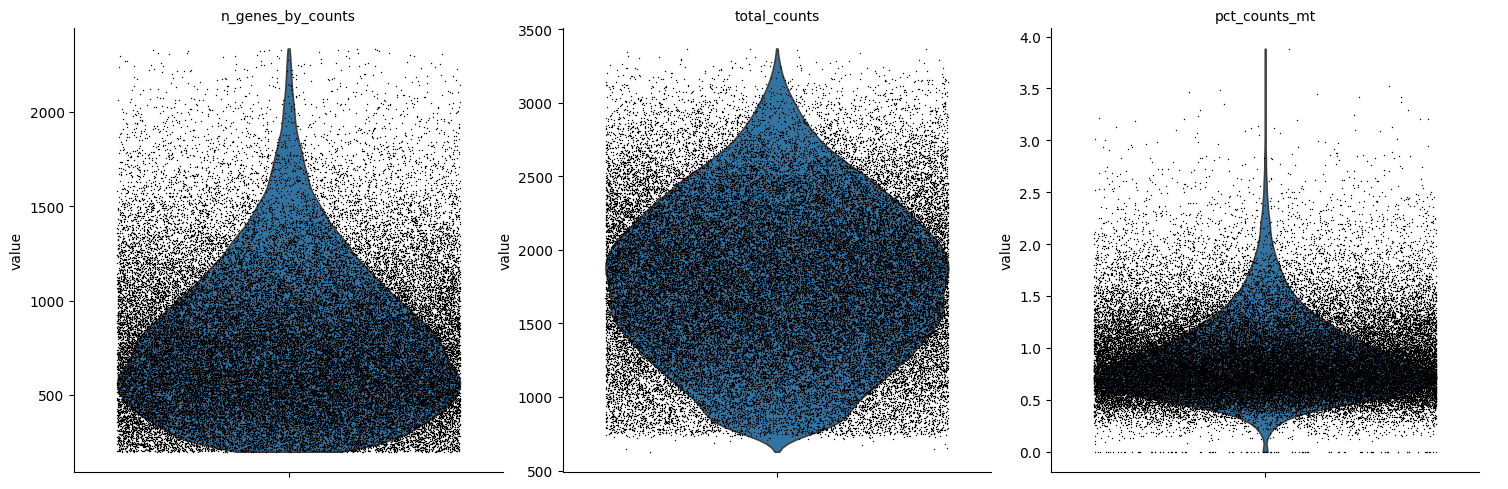

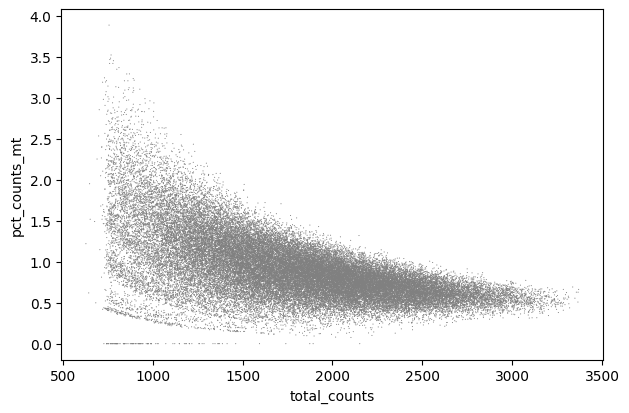

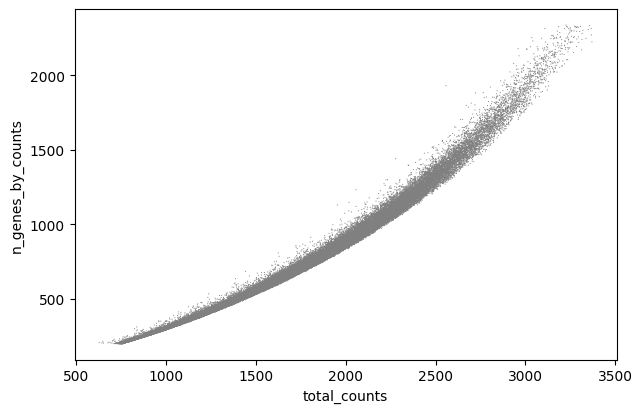

In [3]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

In [4]:
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=5)

adata = adata[adata.obs.n_genes_by_counts < 2000, :].copy()
adata = adata[adata.obs.pct_counts_mt < 3, :].copy()

In [5]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [6]:
# Identify the highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata_hvg = adata[:, adata.var['highly_variable']]

In [7]:
# Regress and scale the data
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

In [10]:


Y = adata.obs['annotation'].to_numpy()
cell_Indexes = adata.obs.index.to_numpy()

# Generate a permutation of index array
np.random.seed(42)  
indices = np.arange(X.shape[0])
np.random.shuffle(indices)

# Shuffle X and Y and Cell_Indexes using the same indices
adata_shuffled = adata[indices].copy()
Y_shuffled = Y[indices]
cell_Indexes_shuffled = cell_Indexes[indices]

In [11]:
# Define the number of folds and L value
k_fold = 5
combination_num = 3

K_list = [3, 5, 7]
L_list = [2, 3, 4]

# Initialize StratifiedKFold and classifier
skf = StratifiedKFold(n_splits=k_fold)

classifier1 = SVC(kernel='rbf', C=1.0, gamma='scale')  
classifier2 = RandomForestClassifier(n_estimators=100, max_depth=None, max_features="sqrt")
classifier3 = RandomForestClassifier(n_estimators=200, max_depth=None, max_features="sqrt")
classifier4 = RandomForestClassifier(n_estimators=100, max_depth=10, max_features="sqrt")
classifier5 = RandomForestClassifier(n_estimators=200, max_depth=None, max_features="log2")
classifier6 = RandomForestClassifier(n_estimators=100, max_depth=None, max_features="log2")
classifier7 = RandomForestClassifier(n_estimators=200, max_depth=10, max_features="log2")
classifiers = [classifier1, classifier2, classifier3, classifier4, classifier5, classifier6, classifier7]
classifiers_names = ["SVC", "Random Forest1", "Random Forest2", "Random Forest3", "Random Forest4", "Random Forest5", "Random Forest6", "Random Forest7"]


In [12]:
scaler = StandardScaler()

for i in range(0,combination_num):
    K = K_list[i]
    L = L_list[i]

    # Initialize predictions dictionary with keys as cell indexes and values as empty lists or arrays of size K
    predictions = {index: np.empty(K, dtype=object) for index in cell_Indexes_shuffled}

    # Metrics storage
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    # Training and prediction
    classifier_index = 0
    for classifier_index in range(0,K):
        for train_index, test_index in skf.split(adata_shuffled, Y_shuffled):
            adata_train = adata_shuffled[train_index].copy() 
            adata_test = adata_shuffled[test_index].copy()
            y_train =  Y_shuffled[train_index]
            y_test = Y_shuffled[test_index]
            cell_indexes_test = cell_Indexes_shuffled[test_index]

            sc.tl.pca(adata_train, svd_solver='arpack', n_comps=50)
            sc.tl.pca(adata_test, svd_solver='arpack', n_comps=50)

            X_train = scaler.fit_transform(np.hstack([adata_train.obsm['X_pca'], adata_train.obsm['spatial']]))
            X_test = scaler.fit_transform(np.hstack([adata_test.obsm['X_pca'], adata_test.obsm['spatial']]))

            classifier = classifiers[classifier_index]

            # Train the model
            classifier.fit(X_train, y_train)
            
            # Predict on the test set
            preds = classifier.predict(X_test)

            # Store predictions in the dictionary using the cell indexes
            for idx, cell_index in enumerate(cell_indexes_test):
                predictions[cell_index][classifier_index] = preds[idx]
            
            # Evaluate predictions
            acc = accuracy_score(y_test, preds)
            prec = precision_score(y_test, preds, average='macro', zero_division=1)
            rec = recall_score(y_test, preds, average='macro')
            f1 = f1_score(y_test, preds, average='macro')

            # Print metrics
            print(f"{classifiers_names[classifier_index]} - Accuracy: {acc}, Precision: {prec}, Recall: {rec}, F1 Score: {f1}")

            # Append metrics to lists for average calculation later
            accuracy_scores.append(acc)
            precision_scores.append(prec)
            recall_scores.append(rec)
            f1_scores.append(f1)
        print("--------------------------------------------------------------------------------------------------------------------------------------------")

    # Calculate and print average scores
    print("Average Accuracy:", np.mean(accuracy_scores))
    print("Average Precision:", np.mean(precision_scores))
    print("Average Recall:", np.mean(recall_scores))
    print("Average F1 Score:", np.mean(f1_scores))

    predicted_annotations = adata.obs['annotation'].copy()

    number_of_changed = 0
    # Process each cell index and its predictions
    for cell_index, preds in predictions.items():
        # Count occurrences of each annotation
        pred_count = Counter(preds)

        most_common_pred, count = pred_count.most_common(1)[0]

        
        if count > L:
            if adata.obs.loc[cell_index, 'annotation'] != most_common_pred:
                predicted_annotations.loc[cell_index] = most_common_pred
                number_of_changed += 1

    print(f"Number of annotations changed for K={K}, L={L}: {number_of_changed}")
    print("<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>")

    adata.obs[f'annotation_K{K}_L{L}'] = predicted_annotations


SVC - Accuracy: 0.4997308065037149, Precision: 0.5643255391745922, Recall: 0.31145339973140496, F1 Score: 0.3170620884854279


KeyboardInterrupt: 

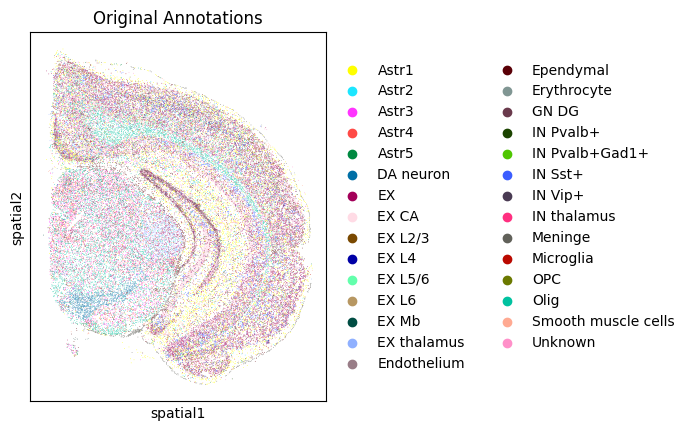

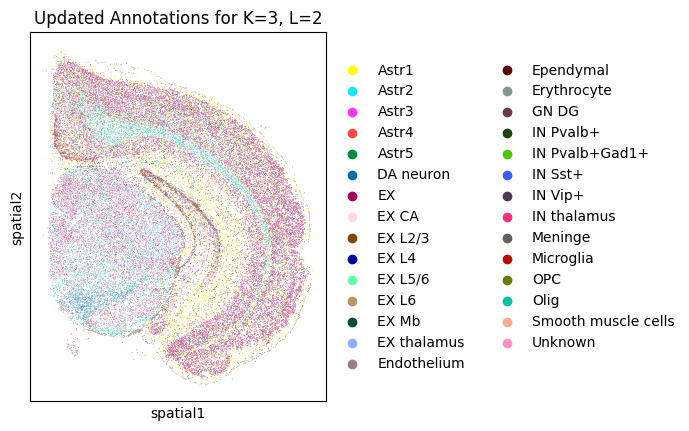

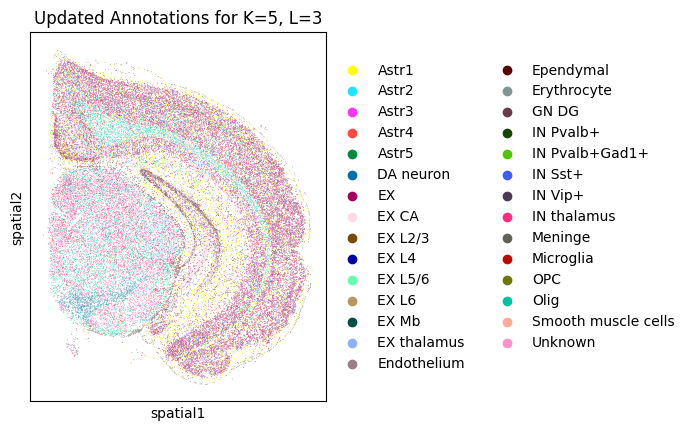

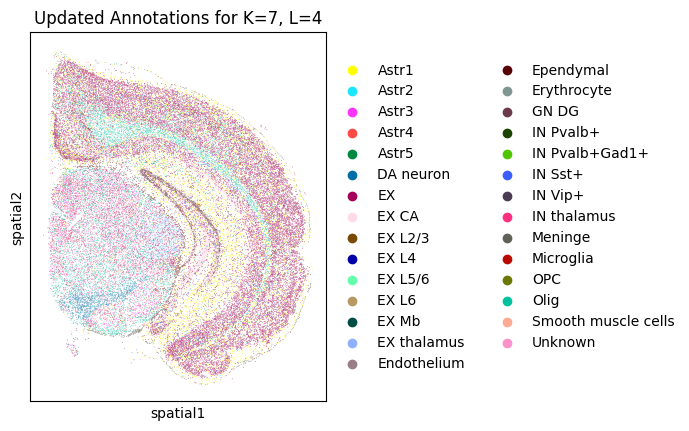

In [28]:
spot_size = 25.0
existing_palette = adata.uns['annotation_colors']
sc.pl.spatial(adata, color='annotation', title=f"Original Annotations", spot_size=spot_size)

for i in range(0,combination_num):
    K = K_list[i]
    L = L_list[i]
    
    adata.uns[f'annotation_K{K}_L{L}_colors'] = existing_palette
    sc.pl.spatial(adata, color=f'annotation_K{K}_L{L}', title=f"Updated Annotations for K={K}, L={L}", spot_size=spot_size)